In [3]:
 import numpy as np
from decimal import Decimal
from matplotlib import pyplot as plt, cm
import matplotlib.gridspec as gridspec
from matplotlib import colormaps as colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lenstronomy.Util.image_util as image_util
from matplotlib_scalebar.scalebar import ScaleBar    
import numpy as np
from skimage.transform import resize
import jax

In [4]:
import lenstronomy
print("Lenstronomy version:", lenstronomy.__version__)
import gigalens
import astropy

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from astropy.io import fits

import gigalens
import tensorflow_probability.substrates.jax as tfp
from corner import corner
from scipy.stats import norm

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear, sie, tnfw, tnfw_ellipse

tfd = tfp.distributions

import jax
from jax import numpy as jnp

Lenstronomy version: 1.12.3


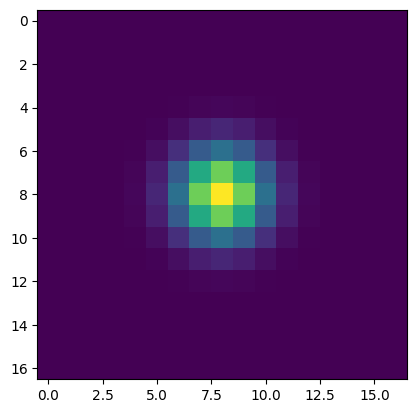

In [5]:
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.1,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': 0.03  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }

psf = PSF(**kwargs_psf)
kernel2 = psf.kernel_point_source
plt.imshow(kernel2)

In [6]:
sim_config = SimulatorConfig(delta_pix=0.03, num_pix=125, supersample=2, kernel=kernel2)

# NFW ellipse

phys_model = PhysicalModel([tnfw_ellipse.TNFW_Ellipse(), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

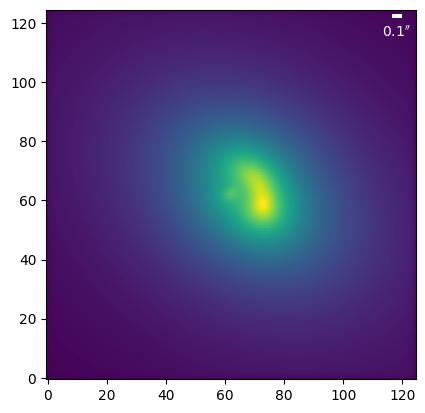

In [7]:
# you'll probably want to change the parameters to get a conventional lens size and more clear arcs
# you can convert M200 and c to Rs and alpha_Rs with lenstronomy: 

# from lenstronomy.Cosmo.lens_cosmo import LensCosmo
# from astropy.cosmology import FlatLambdaCDM
# cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# lens_cosmo = LensCosmo(z_lens=0.49, z_source=1.43, cosmo=cosmo), change redshifts to whatever
# Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=M200, c=c)


lens_light_params = [{'R_sersic': 0.1, 'n_sersic': 3, 'e1': 0.1, 'e2': 0.2, 'center_x': 0, 'center_y': 0, 'Ie': 20}]
source_light_params = [{'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.05, 'e2': -0.15, 'center_x': 0.2, 'center_y': 0, 'Ie': 70}
]
lens_params = [{'Rs': 0.7, 'alpha_Rs': 0.2, 'r_trunc': 10, 'e1': 0.2, 'e2': 0.1, 'center_x': 0, 'center_y': 0}, {'gamma1': 0.02, 'gamma2': 0.01}]

test_full = lens_sim.simulate((lens_params, lens_light_params, source_light_params))
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots()
ax.imshow(test_full)
ax.invert_yaxis()
scalebar = ScaleBar(
        0.03, # deltaPix
        units="\'\'",
        dimension="angle",
        frameon=False,
        fixed_value=0.1, 
        color="white"
)
ax.add_artist(scalebar)
plt.show()

In [8]:
# next few cells aren't very relevant, was just comparing my implementation with lenstronomy to make sure they matched

In [9]:
lens_model_list = ['TNFW_ELLIPSE_POTENTIAL', 'SHEAR']
lensModel = LensModel(lens_model_list=lens_model_list)
source_light_model_list = ['SERSIC_ELLIPSE']
lightModel_source = LightModel(light_model_list=source_light_model_list)
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 2, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}

deltaPix = 0.03

nx = ny = 125
deltaPix = 0.03

# RA/DEC of the *first* pixel centre
ra_at_xy_0  = -0.5 * nx * deltaPix + 0.5 * deltaPix
dec_at_xy_0 = -0.5 * ny * deltaPix + 0.5 * deltaPix

transform_pix2angle = np.array([[deltaPix, 0],
                                [0,        deltaPix]])

kwargs_pixel = dict(nx=nx, ny=ny,
                    ra_at_xy_0=ra_at_xy_0,
                    dec_at_xy_0=dec_at_xy_0,
                    transform_pix2angle=transform_pix2angle)
pixel_grid   = PixelGrid(**kwargs_pixel)

imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)

In [10]:
lens_light_params = [{'R_sersic': 0.1, 'n_sersic': 3, 'e1': 0.1, 'e2': 0.2, 'center_x': 0, 'center_y': 0, 'Ie': 20}]
source_light_params = [{'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.05, 'e2': -0.15, 'center_x': 0.2, 'center_y': 0, 'Ie': 70}
]
lens_params = [{'Rs': 0.7, 'alpha_Rs': 0.2, 'r_trunc': 10, 'e1': 0.2, 'e2': 0.1, 'center_x': 0, 'center_y': 0}, {'gamma1': 0.02, 'gamma2': 0.01}]
kwargs_lens = [
    {'Rs': 0.7, 
     'alpha_Rs': 0.2,
     'r_trunc': 10, 
     'center_x': 0, 
     'center_y': 0,
     'e1': 0.2, 
     'e2': 0.1},
    {'gamma1': 0.02, 
     'gamma2': 0.01}]

kwargs_light_lens = [{'R_sersic': 0.1, 'n_sersic': 3, 
                      'e1': 0.1, 'e2': 0.2, 'center_x': 0, 'center_y': 0, 'amp': 20}]
kwargs_light_source = [{'R_sersic': 1.5, 'n_sersic': 1.5, 'e1': 0.05, 'e2': -0.15,
                        'center_x': 0.2, 'center_y': 0, 'amp': 70}
]

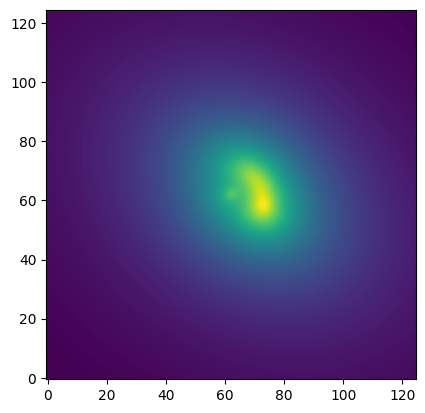

In [11]:
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)
plt.imshow(image, origin='lower')

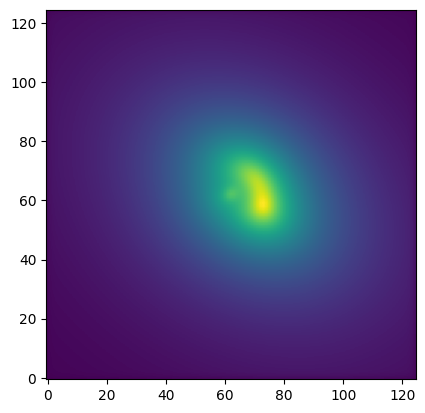

In [12]:
plt.imshow(test_full, origin='lower')

In [13]:
resids = test_full - image

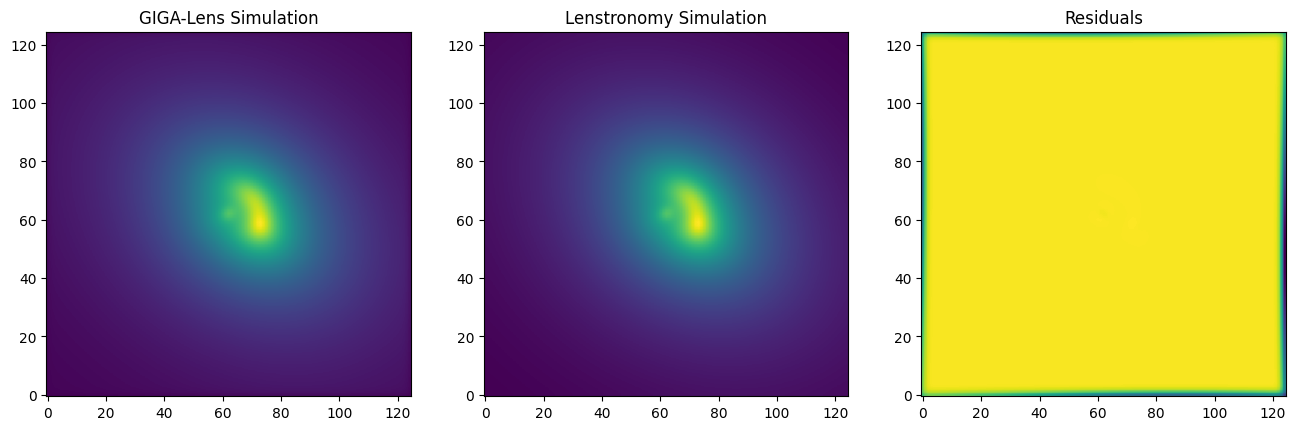

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(test_full, origin='lower')
ax[0].set_title("GIGA-Lens Simulation")
ax[1].imshow(image, origin='lower')
ax[1].set_title("Lenstronomy Simulation")
ax[2].imshow(resids, origin='lower')
ax[2].set_title("Residuals")
plt.show()

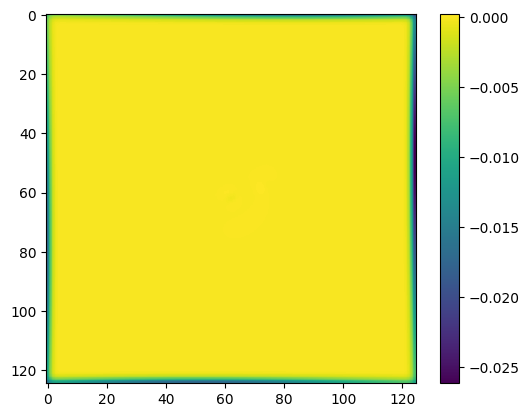

In [15]:
plt.imshow(resids)
plt.colorbar()

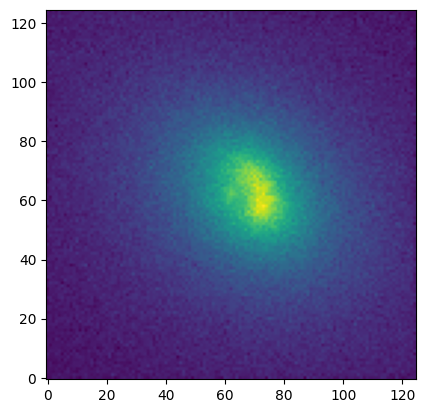

In [16]:
obs = test_full
# adding noise
import lenstronomy.Util.image_util as image_util
exp_time = 1200  
background_rms = 1.615479000000E-02 
poisson = image_util.add_poisson(obs, exp_time=exp_time)
bkg = image_util.add_background(obs,sigma_bkd=background_rms) 
observed_img = obs + bkg + poisson
plt.imshow(observed_img, origin='lower')
plt.show()

In [17]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                Rs=tfd.LogNormal(jnp.log(1), 0.15), 
                alpha_Rs=tfd.TruncatedNormal(0.3, 0.1, 0.05, 0.55),
                r_trunc = tfd.TruncatedNormal(12, 5, 2, 100),
                e1=tfd.Normal(0, 0.2),
                e2=tfd.Normal(0, 0.2),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.1), 0.25),
                n_sersic=tfd.Uniform(0.5, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.1, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(30), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.5), 0.15),
                n_sersic=tfd.Uniform(0.5, 6),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(70), 0.5), # look at pixel values in arcs
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [18]:
sim_config = SimulatorConfig(delta_pix=0.03, num_pix=125, supersample = 2, kernel=kernel2)
phys_model = PhysicalModel([tnfw_ellipse.TNFW_Ellipse(), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=1200)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [27]:
import optax

fitter = ModellingSequence(phys_model, prob_model, sim_config)
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/2, 
                                      power=0.5, transition_steps=750)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate = model_seq.MAP(opt, n_samples=950, num_steps=1000, seed=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

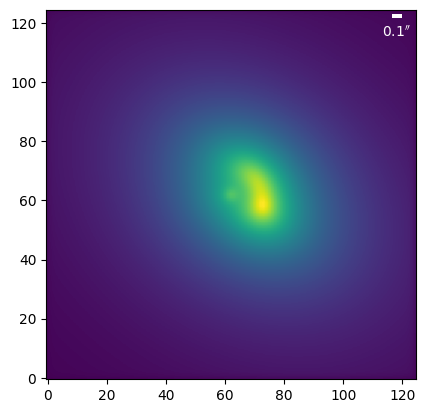

In [28]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=948), map_estimate)[0]
best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]
mapimg = prob_model.bij.forward(list(best.T)) # best MAP Img
sim = lens_sim.simulate(mapimg)
fig, ax = plt.subplots()
ax.imshow(sim)
ax.invert_yaxis()
scalebar = ScaleBar(
        0.03,
        units="\'\'",
        dimension="angle",
        frameon=False,
        fixed_value=0.1,
        color="white"
)
ax.add_artist(scalebar)
plt.show()

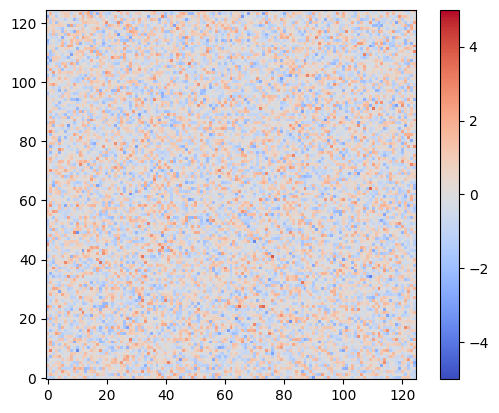

In [31]:
err_map = np.sqrt(background_rms**2+sim/1200)
observed_img2 = observed_img.astype(np.float32)
resid = sim - observed_img2
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5, origin='lower')
plt.colorbar()

In [32]:
print('Chi-square:', np.mean((resid/err_map)**2))
prob_model.bij.forward(list(best.T))

Chi-square: 0.98070365


[[{'r_trunc': Array([10.064274], dtype=float32),
   'e2': Array([0.09096595], dtype=float32),
   'e1': Array([0.21921368], dtype=float32),
   'center_y': Array([0.0101227], dtype=float32),
   'center_x': Array([0.00874499], dtype=float32),
   'alpha_Rs': Array([0.23590373], dtype=float32),
   'Rs': Array([0.97715575], dtype=float32)},
  {'gamma2': Array([0.02302862], dtype=float32),
   'gamma1': Array([0.07714644], dtype=float32)}],
 [{'n_sersic': Array([3.3719733], dtype=float32),
   'e2': Array([0.04597631], dtype=float32),
   'e1': Array([0.02976546], dtype=float32),
   'center_y': Array([-0.00589136], dtype=float32),
   'center_x': Array([-0.0001793], dtype=float32),
   'R_sersic': Array([0.07355651], dtype=float32),
   'Ie': Array([27.5422], dtype=float32)}],
 [{'n_sersic': Array([1.529712], dtype=float32),
   'e2': Array([-0.16556749], dtype=float32),
   'e1': Array([-0.00510713], dtype=float32),
   'center_y': Array([0.00012028], dtype=float32),
   'center_x': Array([0.18313739]

  0%|          | 0/2400 [00:00<?, ?it/s]

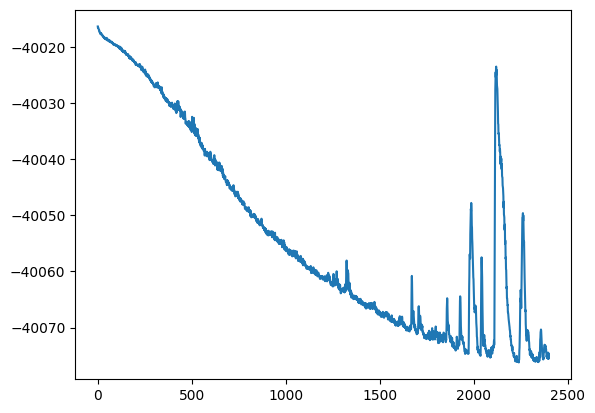

In [33]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6*5, end_value=-3e-3, 
                                      power=2, transition_steps=750)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=1500, num_steps=2400)
plt.plot(loss_hist)

In [34]:
samples = fitter.HMC(qz, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=150,
                                   num_burnin_steps=950, num_results=2000)
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
prob_model.pack_bij.forward(list(rhat))

Sampling took 324.2s


[[{'r_trunc': Array(1.0055918, dtype=float32),
   'e2': Array(1.0001894, dtype=float32),
   'e1': Array(1.0010078, dtype=float32),
   'center_y': Array(1.0001427, dtype=float32),
   'center_x': Array(1.001286, dtype=float32),
   'alpha_Rs': Array(1.0009565, dtype=float32),
   'Rs': Array(1.0008019, dtype=float32)},
  {'gamma2': Array(1.0002165, dtype=float32),
   'gamma1': Array(1.0007323, dtype=float32)}],
 [{'n_sersic': Array(1.0016469, dtype=float32),
   'e2': Array(1.0001457, dtype=float32),
   'e1': Array(1.000327, dtype=float32),
   'center_y': Array(1.0004549, dtype=float32),
   'center_x': Array(1.0003188, dtype=float32),
   'R_sersic': Array(1.0006002, dtype=float32),
   'Ie': Array(1.0000074, dtype=float32)}],
 [{'n_sersic': Array(1.0002513, dtype=float32),
   'e2': Array(1.0002389, dtype=float32),
   'e1': Array(1.0008364, dtype=float32),
   'center_y': Array(1.0002612, dtype=float32),
   'center_x': Array(1.00065, dtype=float32),
   'R_sersic': Array(1.0004591, dtype=float3

In [35]:
import corner as corner

smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 23))
smp_physical = prob_model.bij.forward(list(smp.T))
def get_corner_samples(samples, key):
    """
    Key tells you lens_mass (1), lens_light (2), or source_light (3)
    """
    return_list = []

    if key == 1:
        for i in samples[0][0].keys():
            return_list.append(samples[0][0][i])
        for j in samples[0][1].keys():
            return_list.append(samples[0][1][j])

    if key == 2:
        for i in samples[1][0].keys():
            return_list.append(samples[1][0][i])

    if key == 3:
        for i in samples[2][0].keys():
            return_list.append(samples[2][0][i])
            
    return np.stack(return_list).T

mass_samps = get_corner_samples(smp_physical, 1)
mass_samps.shape

(96000, 9)

In [45]:
lens_light_params = [{'n_sersic': 3, 'e2': 0.2, 'e1': 0.1, 'center_y': 0, 'center_x': 0, 'R_sersic': 0.1, 'Ie': 20}]
source_light_params = [{'n_sersic': 1.5, 'e2': -0.15, 'e1': 0.05, 'center_y': 0, 'center_x': 0.2, 'R_sersic': 1.5, 'Ie': 70}
]
lens_params = [{'r_trunc': 10, 'e2': 0.1, 'e1': 0.2, 'center_y': 0, 'center_x': 0, 'alpha_Rs': 0.2, 'Rs': 0.7}, {'gamma2': 0.01, 'gamma1': 0.02}]

In [46]:
def get_truth(lens_params, key):
    return_list = []
    if key == 1:
        for i in lens_params[0].keys():
            return_list.append(lens_params[0][i])
        for j in lens_params[1].keys():
            return_list.append(lens_params[1][j])
    if key == 2:
        for i in lens_light_params[0].keys():
            return_list.append(lens_light_params[0][i])
    if key == 3:
        for i in source_light_params[0].keys():
            return_list.append(source_light_params[0][i])
    return np.stack(return_list).T

true_mass = get_truth(lens_params, key=1)
true_mass

array([10.  ,  0.1 ,  0.2 ,  0.  ,  0.  ,  0.2 ,  0.7 ,  0.01,  0.02])

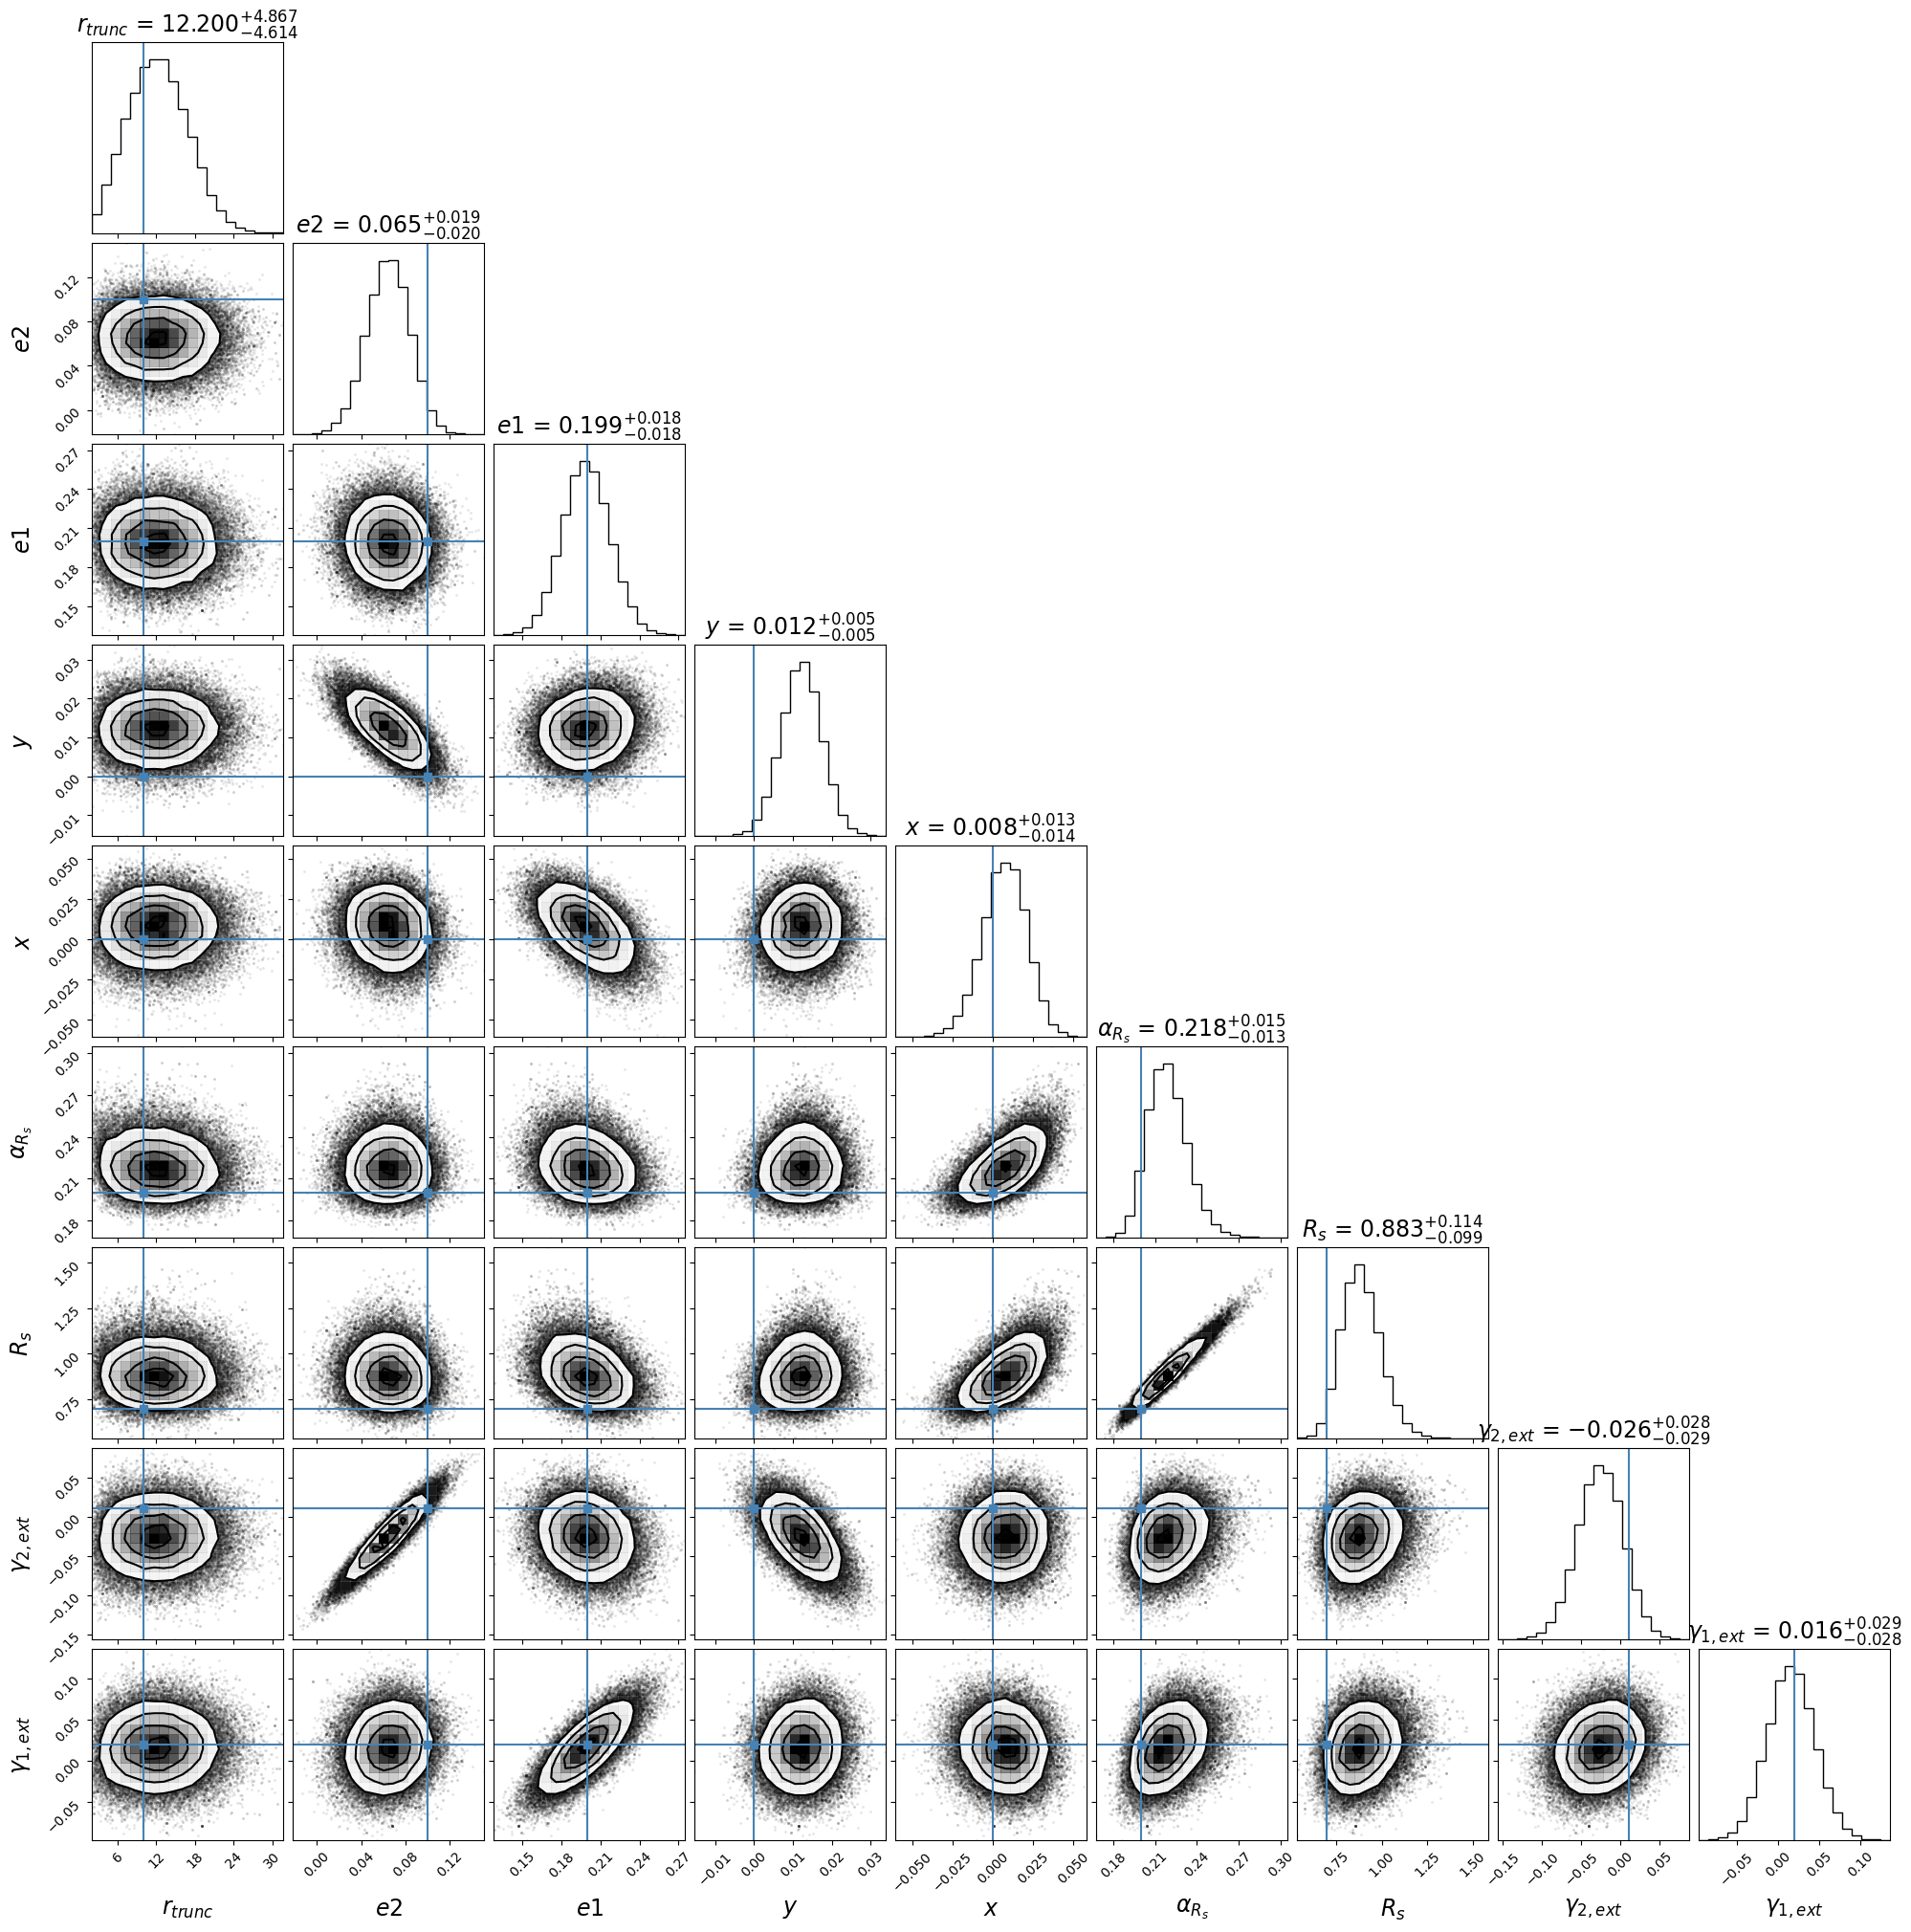

In [47]:
corner.corner(mass_samps,
       show_titles=True, title_fmt='.3f', truths=true_mass,
       labels=[r'$r_{trunc}$', r'$e2$', r'$e1$', r'$y$', r'$x$', r'$\alpha_{R_s}$', r'$R_s$', 
               r'$\gamma_{2,ext}$', r'$\gamma_{1,ext}$',
              #  r'$\theta^{sec}_E$', r'$\epsilon^{sec}_1$', r'$\epsilon^{sec}_2$', r'$x^{sec}$', r'$y^{sec}$',
               ], label_kwargs = {'fontsize': 17}, title_kwargs = {'fontsize': 17},);